# Biomarker Identification

In [1]:
# adding the project root inside the python path
import sys
import os

sys.path.insert(0, os.path.abspath('..'))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from bioinfokit import visuz
from analysis.preprocess import PreprocessPipeline

In [3]:
pipeline = PreprocessPipeline(
    datasets_path='../../dataset/first_disease_sel',
    disease_col_name='DISEASE',
    output_dir='/tmp/chl/',
)

pipeline.execute_pipeline()
df = pipeline.dataset

INFO:root:Starting pipeline
INFO:root:Loading datasets
INFO:root:Skipping file ../../dataset/first_disease_sel/.DS_Store
INFO:root:Inspecting directory ../../dataset/first_disease_sel/GS
INFO:root:Setting disease as GS
INFO:root:Loading file ../../dataset/first_disease_sel/GS/eGSE117146m.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/NALD
INFO:root:Setting disease as NALD
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE34308m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE117647m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE85804m.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/A1A
INFO:root:Setting disease as A1A
INFO:root:Loading file ../../dataset/first_disease_sel/A1A/A1A_deficiency_GSE109516_pbmc.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/MCM
INFO:root:Setting disease as MCM
INFO:root:Loading file ../../dataset/first_disease_sel/MCM/MCM_GSE149607.csv
INFO:root

In [4]:
pipeline.test_set

,DENR,VAT1,IMPDH1,TBXAS1,RBBP9,BBS7,ELAC1,SRSF6,MCMBP,ARFGEF1,...,TCTN1,KIAA0319L,PORCN,NFU1,C22ORF46,DHCR7,AHI1,WDR70,HTRA2,CHSY1
DIABETE_174,0.094754,0.288636,0.000000,0.264710,0.247242,1.000000,0.507144,0.902889,0.648046,0.308582,...,1.000000,0.695313,0.936063,0.165351,0.310828,0.167896,0.567417,0.000000,0.207810,0.475189
DIABETE_56,0.277331,0.405956,0.312673,0.181167,0.291901,0.222404,0.514450,0.401610,1.000000,0.479253,...,0.209928,0.741056,0.716076,0.096801,0.889075,0.081838,0.118294,0.820177,0.181526,0.452901
A1A_93,0.591643,0.017724,0.302856,0.581257,0.290238,0.482913,0.526860,0.709246,0.718461,0.399296,...,0.585813,0.429138,0.401148,0.312384,0.462809,0.257784,0.056253,0.637819,0.215010,0.238494
A1A_6,0.786653,0.015069,0.713856,0.426961,0.471643,0.607582,0.406842,0.511001,0.532344,0.606050,...,0.489581,0.422112,0.219896,0.480976,0.412000,0.222655,0.204960,0.381015,0.241998,1.000000
DIABETE_169,0.000000,0.422762,1.000000,0.036473,0.532541,0.308194,1.000000,0.778711,0.763064,1.000000,...,0.000000,0.482701,0.698921,1.000000,0.261275,0.046498,0.299582,0.089797,0.813931,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A1A_122,0.636630,0.062269,0.159843,0.121331,0.085039,0.237604,0.341180,0.701879,0.183952,0.263154,...,0.318371,0.233839,0.378869,0.207763,0.364882,0.468825,0.103041,0.286758,0.276510,0.133633
A1A_89,0.788880,0.031043,0.334127,0.457611,0.476834,0.430721,0.540185,0.677663,0.421034,0.462834,...,0.401855,0.402945,0.430156,0.377483,0.449062,0.274236,0.193043,0.415439,0.261866,0.225906
A1A_52,0.732564,0.040328,0.226747,0.574467,0.295824,0.332165,0.396442,0.620837,0.426227,0.451835,...,0.433487,0.332086,0.468571,0.333081,0.486724,0.272048,0.105960,0.520527,0.208436,0.273609
DIABETE_102,0.184855,0.199214,0.315457,0.248453,0.221865,0.332168,0.204918,0.163994,0.271330,0.445573,...,0.161049,0.183069,0.096552,0.153005,0.228093,0.229508,0.275269,0.070461,0.657005,0.285797


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, GS_1 to DIABETE_175
Columns: 4602 entries, DENR to CHSY1
dtypes: float64(4601), object(1)
memory usage: 14.0+ MB


In [6]:
df.head()

,DENR,VAT1,IMPDH1,TBXAS1,RBBP9,BBS7,ELAC1,SRSF6,MCMBP,ARFGEF1,...,TCTN1,KIAA0319L,PORCN,NFU1,C22ORF46,DHCR7,AHI1,WDR70,HTRA2,CHSY1
GS_1,0.815874,0.013194,0.766790,0.630670,1.000000,0.536049,0.416553,0.368155,0.604788,0.661765,...,0.140500,0.530904,0.360362,0.605948,0.726300,0.587945,0.649803,0.667960,0.571115,0.722252
GS_2,0.626026,0.263858,0.716785,0.812825,0.776387,1.000000,0.601733,0.510130,0.550964,0.545657,...,0.279813,0.487718,0.676896,0.535835,0.454426,0.039593,0.125129,0.443654,0.950642,0.549896
GS_3,0.855962,0.220193,0.807962,0.385137,0.764627,0.418152,0.582273,0.522156,0.458199,0.739447,...,0.683350,0.401348,0.605912,0.334107,0.833479,0.721957,0.826613,0.438925,0.529630,0.511455
GS_4,0.683033,0.189836,0.716585,0.867507,0.037812,0.981608,0.860081,0.000000,0.346713,0.344655,...,0.541577,0.247969,0.590239,1.000000,0.669003,0.000000,0.364299,0.284135,0.000000,0.811292
GS_5,0.389242,0.239721,0.881733,0.484069,0.468599,0.076904,0.526743,0.742108,0.000000,0.528164,...,0.549061,0.769927,0.745037,0.328623,0.659389,0.800469,0.742716,0.635996,0.572933,0.512023


## Inspecting dataset we have built

DIABETE    176
A1A        128
NALD        38
GS          29
MCM         28
Name: DISEASE, dtype: int64


<AxesSubplot:>

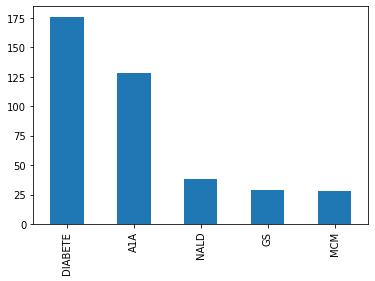

In [7]:
# plotting the number of sample for each disease
disease = df['DISEASE'].value_counts()
print(disease)
disease.plot.bar()

## Genes' visualization

In [8]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']

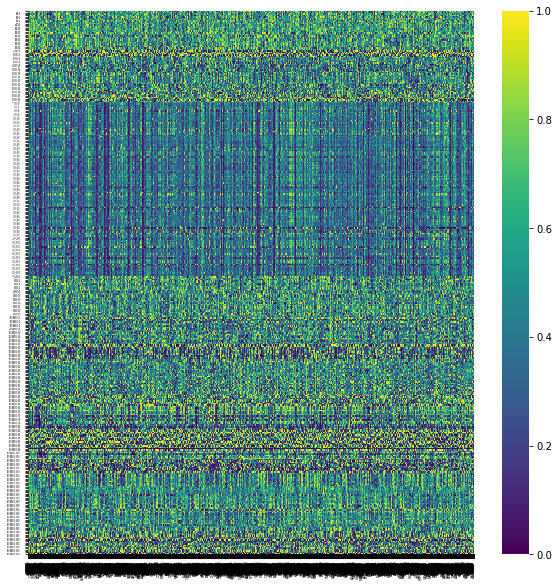

In [9]:
visuz.gene_exp.hmap(df=df[data_cols], cmap='viridis', rowclus=False, colclus=False, dim=(10, 10), tickfont=(3, 2), show=True)

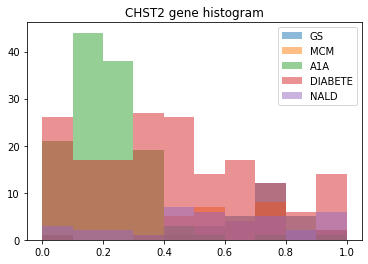

In [10]:
gene = 'CHST2'
plt.hist(df.loc[df['DISEASE']=='GS', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='MCM', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='A1A', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='DIABETE', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='NALD', gene], bins=10, alpha=0.5)

plt.title(gene+' gene histogram')  
plt.legend(['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'])
  
plt.show()

## Biomarker Identification pipeline

1. Pairwise statistical test
2. Gene selection for each pair of disease
3. Gene intersection/union

In [11]:
from collections.abc import Callable
import itertools
def pairwise_hyp_testing(df: pd.DataFrame, disease_col: str, diseases: list[str], 
                         test: Callable[[pd.Series, pd.Series], float]) -> dict[tuple[str,str], list[float]]:
    """
    This function computes the pairwise hypothesis testing between diseases.
    :param df: dataframe with expression levels
    :param disease_col: the name of the column where the type of disease is represented
    :param diseases: a list of diseases to test
    :param test: the function of the testing
    :return dictionary of pairwise test. Example: ('DIABETE', 'A1A') -> [test_gene1, test_gene2,..., test_geneN]
    """
    combinations = list(itertools.combinations(diseases, 2))
    pairwise_test = dict()
    
    for pair in combinations:
        df1 = df[df[disease_col]==pair[0]].copy()
        df1.drop(disease_col, axis=1, inplace=True)
        df2 = df[df[disease_col]==pair[1]].copy()
        df2.drop(disease_col, axis=1, inplace=True)
        pair_test = []
        
        for gene in df1:
            gene_test = test(df1[gene], df2[gene])
            pair_test.append(gene_test)
        
        pairwise_test[pair] = pair_test
    
    return pairwise_test


In [12]:
from scipy.stats import ttest_ind
def t_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the t-test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pvalue
    """
    # ttest_ind returns tuple(statistic, pvalue)
    return ttest_ind(s1, s2)[1]

In [13]:
import math
def log2fc(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the log-fold change between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return log2-Fold Change
    """
    return math.log(s1.mean()/s2.mean(), 2)

In [14]:
from scipy.stats import ranksums
def wilcoxon_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the Wilcoxon's test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pValue of Wilcoxon's test
    """
    return ranksums(s1, s2)[1]

In [15]:
from scipy.stats import ks_2samp
def ks_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the Kolmogorov-Smirnov test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pValue of KS test
    """
    return ks_2samp(s1, s2)[1]

In [16]:
import math
def gene_selection(stat_test: dict[tuple[str,str], list[float]], gene_names: list[str], 
                   alpha: float, correction: str = None, log2fc: dict[tuple[str,str], list[float]] = None,
                  log2fc_thr: float = None)-> dict[tuple[str,str], list[str]]:
    """
    This function selects genes for each pair of diseases based on a given threshold, eventually with correction.
    :param stat_test: dictionary with pvalues of pairwise tests 
                        Example of entry ('Disease1', 'Disease2') -> [pValues_gene1,...,pValues_geneN]
    :param gene_names: list of gene names. This list MUST have the same length of each value of the dictionary
                        and the same order
    :param alpha: the significance to test the pValue
    :param correction: type of correction to apply to the filter. 
                        Possible values ['bonferroni', '2fc', None]
                        'bonferroni': Bonferroni correction
                        '2fc': log2FC - pValue selection. It requires log2fc and log2fc_thr parameters
                        None: by default negative log10 comparison
    :param log2fc: dictionary with log2fc of pairwise tests. Needed if correction='2fc'. MUST have the same length
                    and order of gene_names.
    :param log2fc_thr: threshold for log2fc. Needed if correction='2fc'
    :return dictionary with filtered genes by pValues
    """
    a = alpha
    f = lambda pVal: -math.log(pVal,10)
    # Check if you have to compare log2FC with pValue
    volcano = False
    threshold_check = lambda pVal, alpha: pVal > alpha
    
    # Arguments validation
    if correction == 'bonferroni':
        a = f(a/len(stat_test))
    elif correction == '2fc':
        if log2fc == None or log2fc_thr == None:
            raise ValueError("Correction='2fc', you must define log2fc and log2fc_thr")
        else:
            a = f(a)
            threshold_check = lambda pVal, alpha, l2fc, l2fc_thr: pVal > alpha and abs(l2fc) > l2fc_thr
            volcano = True
    else:
        a = f(a)
        
    
    pairwise_genes_dict = {}
    for key, value in stat_test.items():
        selected_genes = []
        # Double comparison log2fc - pvalue
        if volcano:
            curr_log2fc = log2fc[key]
            for i in range(len(value)):
                if threshold_check(f(value[i]), a, curr_log2fc[i], log2fc_thr):
                    selected_genes.append(gene_names[i])
        # Comparison of pvalue
        else: 
            for i in range(len(value)):
                if threshold_check(f(value[i]), a):
                    selected_genes.append(gene_names[i])
        pairwise_genes_dict[key] = selected_genes
    
    return pairwise_genes_dict

In [17]:
def gene_intersection(pairwise_genes: dict[tuple[str,str], list[str]], verbose: bool = False ) -> list[str]:
    """
    This function computes the intersection between list of genes
    :param pairwise_genes: dictionary with pairwised diseases and list of genes
    :param verbose: print the size of each intersection
    :return intersection between genes
    """
    intersection = []
    first = True
    for key, value in pairwise_genes.items():
        if not first:
            intersection = [gene for gene in intersection if gene in value]
        else:
            intersection = value
            first=False
        if verbose:
            print(len(intersection))
    return intersection

In [29]:
def gene_union(pairwise_genes: dict[tuple[str,str], list[str]], verbose: bool = False ) -> list[str]:
    """
    This function computes the union between list of genes
    :param pairwise_genes: dictionary with pairwised diseases and list of genes
    :param verbose: print the size of each union
    :return union between genes
    """
    union = set()
    first = True
    for key, value in pairwise_genes.items():
        if not first:
            union = union.union(set(value))
        else:
            union = set(value)
            first=False
        if verbose:
            print(len(union))
    return list(union)

## Statistical test visualizations

In [19]:
import itertools
diseases = ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']
combinations = list(itertools.combinations(diseases, 2))
combinations

[('GS', 'MCM'),
 ('GS', 'A1A'),
 ('GS', 'DIABETE'),
 ('GS', 'NALD'),
 ('MCM', 'A1A'),
 ('MCM', 'DIABETE'),
 ('MCM', 'NALD'),
 ('A1A', 'DIABETE'),
 ('A1A', 'NALD'),
 ('DIABETE', 'NALD')]

In [20]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], t_test)

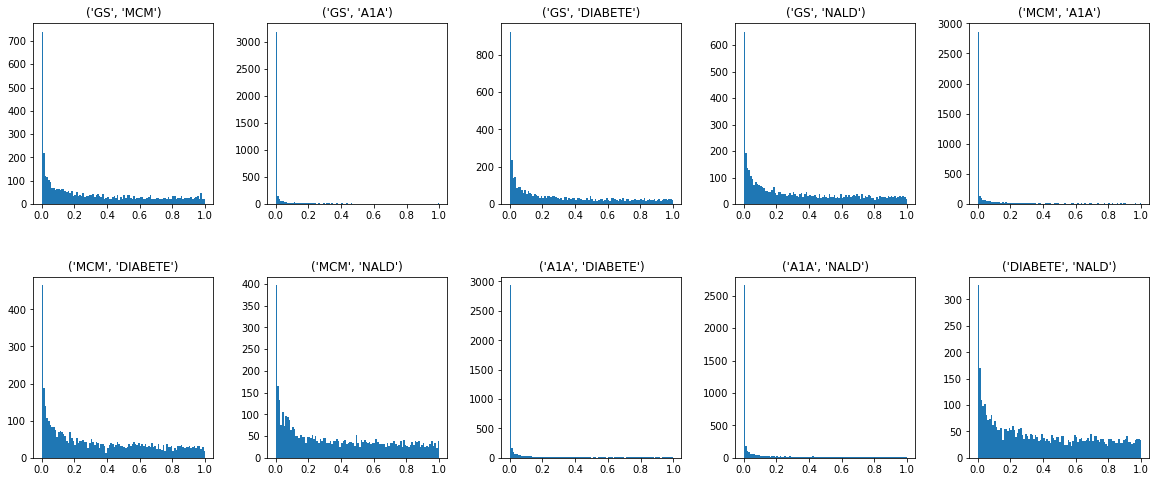

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].hist(testing[key], bins=100)
    axs[i].set_title(str(key))
    i += 1

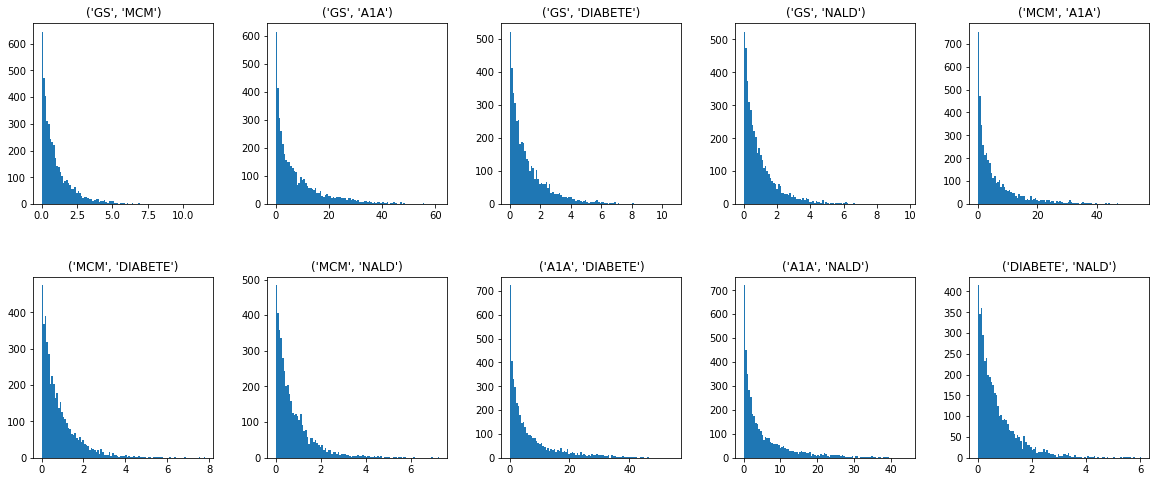

In [22]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

f = lambda x: -math.log(x,10)
i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].hist([f(pval) for pval in value], bins=100)
    axs[i].set_title(str(key))
    i += 1

In [23]:
testing_l2fc = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], log2fc)

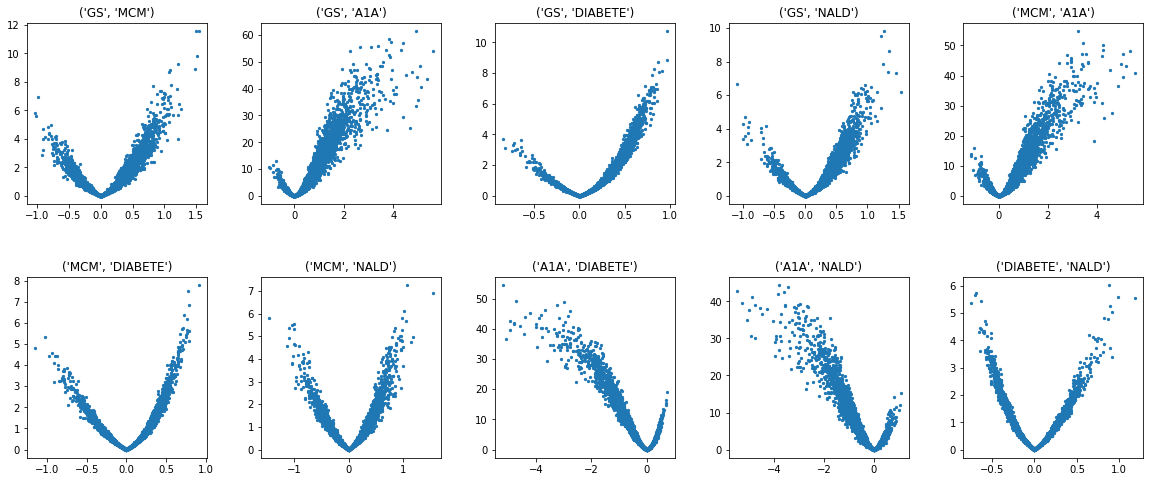

In [24]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

f = lambda x: -math.log(x,10)
i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].scatter(testing_l2fc[key], [f(pval) for pval in value], s=5)
    axs[i].set_title(str(key))
    i += 1

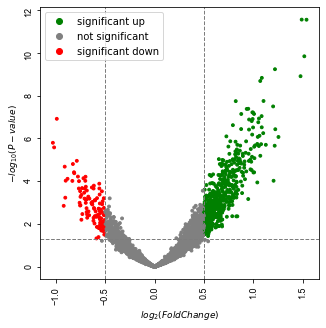

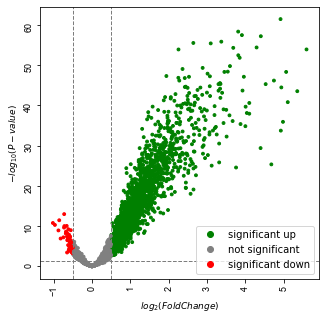

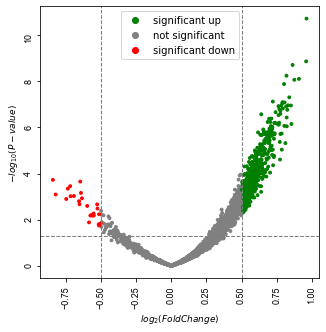

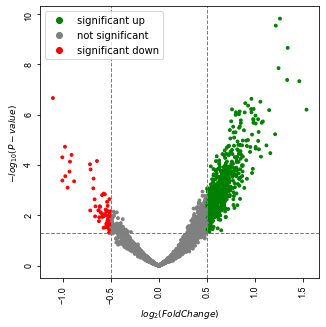

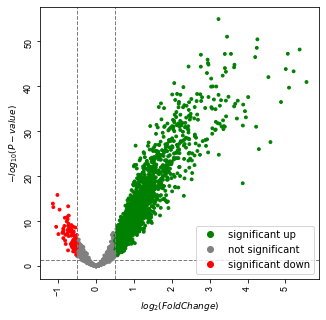

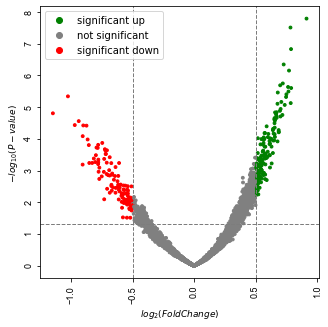

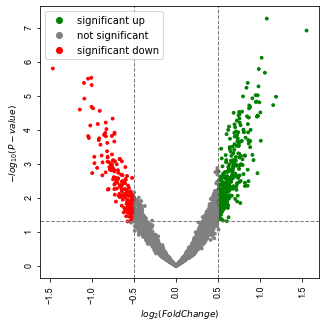

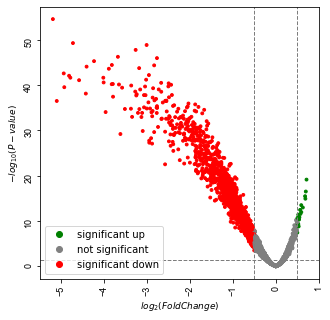

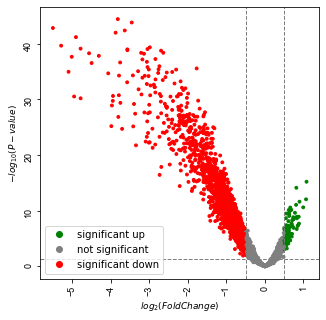

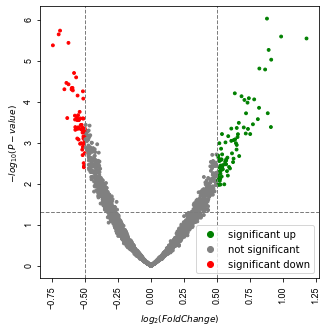

In [25]:
for key, value in testing.items():
    volcano = pd.DataFrame(data={'Genes': data_cols, 'log2FC': testing_l2fc[key], 'pvalue': value})
    visuz.GeneExpression.volcano(df=volcano, lfc='log2FC', pv='pvalue',
                             #geneid='Genes', genenames='deg',
                             # threshold pair (right, left) always positive
                             lfc_thr=(0.5, 0.5), pv_thr=(0.05, 0.05), 
                             figname=str(key), dim=(5,5), sign_line=True, plotlegend=True, show=True)

## pValue - 2LFC test

In [27]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.005, '2fc', testing_l2fc, 0.5)

In [30]:
union = gene_union(genes_dict)

In [31]:
len(union)

3184

# T-test

In [32]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], t_test)

In [33]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [34]:
union = gene_union(genes_dict)

In [36]:
len(union)

3960

# Wilcoxon test

In [37]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], wilcoxon_test)

In [38]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [39]:
union = gene_union(genes_dict)

In [41]:
len(union)

3945

# KS test

In [42]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], ks_test)

In [43]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, 'bonferroni')

In [44]:
union = gene_union(genes_dict)

In [45]:
len(union)

4420

## Extract dataset after statistical test

In [48]:
df[union+['DISEASE']]

,DENR,VAT1,BBS7,ELAC1,MCMBP,MEA1,HEATR3,PAK1IP1,RAD51B,LMO2,...,ATF4,IBTK,DIMT1,TCTN1,PORCN,DHCR7,AHI1,HTRA2,GCDH,DISEASE
GS_1,0.815874,0.013194,0.536049,0.416553,0.604788,0.876223,0.610077,0.538353,0.616900,1.000000,...,0.286920,0.668437,0.763232,0.140500,0.360362,0.587945,0.649803,0.571115,0.677165,GS
GS_2,0.626026,0.263858,1.000000,0.601733,0.550964,0.586813,0.238751,0.276459,0.311709,0.709485,...,0.258446,0.630284,0.649654,0.279813,0.676896,0.039593,0.125129,0.950642,0.445971,GS
GS_3,0.855962,0.220193,0.418152,0.582273,0.458199,0.470584,0.000000,0.546360,0.289549,0.843185,...,0.402271,0.846045,0.278716,0.683350,0.605912,0.721957,0.826613,0.529630,0.500441,GS
GS_4,0.683033,0.189836,0.981608,0.860081,0.346713,0.929449,0.606279,0.402629,0.470769,0.561961,...,0.318651,0.367958,0.722296,0.541577,0.590239,0.000000,0.364299,0.000000,0.344320,GS
GS_5,0.389242,0.239721,0.076904,0.526743,0.000000,0.424012,0.317285,0.000000,0.837261,0.793858,...,0.282025,0.599831,0.602443,0.549061,0.745037,0.800469,0.742716,0.572933,0.369863,GS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DIABETE_171,0.349993,1.000000,0.000000,0.817308,0.837881,0.207969,1.000000,1.000000,0.715913,0.240900,...,0.094933,0.877454,0.702126,0.292366,0.417302,1.000000,0.000000,0.153811,1.000000,DIABETE
DIABETE_172,0.489424,0.309898,0.709971,0.362517,0.406265,0.021749,0.522070,0.392785,0.936815,0.876058,...,0.278994,0.972251,0.917355,0.194755,1.000000,0.316045,0.532157,0.180186,0.439196,DIABETE
DIABETE_173,1.000000,0.064056,0.778073,0.417416,1.000000,0.000000,0.342595,0.427170,0.774374,0.621916,...,0.000000,1.000000,0.973759,0.164388,0.730240,0.646433,0.170830,0.000000,0.648852,DIABETE
DIABETE_174,0.094754,0.288636,1.000000,0.507144,0.648046,0.107625,0.374407,0.000000,1.000000,0.423487,...,0.030785,0.543820,0.096959,1.000000,0.936063,0.167896,0.567417,0.207810,0.998363,DIABETE
